<a href="https://colab.research.google.com/github/Mahshad-RM/MOR/blob/old/Assignment2_1DLROM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

import numpy as np

##<font color="#FFD700"> **Linear elasticity**: material design for a stunt training facility

### 🔍 Problem Summary: Designing a Dual-Layer Stunt Floor (2D Linear Elasticity)

###  Objective
A company is developing a dual-layer floor for stunt training. The aim is to:
- Maximize shock absorption (to reduce injury on falls) with a soft top layer
- Maintain stability with a stiff bottom layer

###  Physical Setup
Modeling a 2D square domain:
$$
Ω = (0,1)^2
$$
This represents a portion of the floor.

The floor experiences:
- Impact from above (like a foot strike)
- Gravity
- Dynamic response modeled using linear elasticity equations

###  Mathematical Model
####  PDE (Simplified Description)
Unknown displacement field:
$$
\mathbf{u}(x,y,t) \in \mathbb{R}^2
$$

Linear elasticity PDE:
$$
\frac{\partial^2 \mathbf{u}}{\partial t^2} = \nabla \cdot \left(\lambda \nabla \cdot \mathbf{u} \cdot I + \mu (\nabla \mathbf{u} + \nabla \mathbf{u}^\top)\right) + \mathbf{g}
$$

Where:
- $\lambda(x,y)$ and $\mu(x,y)$ are Lamé parameters (vary with depth $y$)
- $\mathbf{g} = [0,1]^\top$ is gravity

Impact force (vertical pulse at top boundary):
$$
\mathbf{f}(t) = \begin{cases}
[0, 5\sin(2\omega t)] & t \in (0, 0.5] \\
[0, 0] & t > 0.5
\end{cases}
$$

###  Material Parameters
Two layers controlled by $\varphi \in [0.5, 0.9]$ (top layer thickness):

$$
\lambda(x,y), \mu(x,y) = \begin{cases}
10 & y \geq \varphi \text{ (top soft layer)} \\
50 & y < \varphi \text{ (bottom stiff layer)}
\end{cases}
$$

Single parameter per simulation: $\mu := \varphi \in [0.5, 0.9]$



### Project Goal
Build a fast, data-driven ROM to:
- Enable real-time predictions
- Help engineers explore material designs (varying $\varphi$)
- Avoid expensive FOM simulations

In [2]:
# FOM discretization
mesh = fe.unitsquaremesh(40, 40)
Vh = fe.space(mesh, 'CG', 1, vector_valued = True)
clc()

<font color= '#orange'>   Data Download and Load :

In [3]:
# Dataset (parameters and FOM simulations)
import gdown
gdown.download(id = "1XYPnIpVVc9jkd7LwMhC-FYoV2RTnTK8L", output = "floor.npz")
clc()

data = np.load("floor.npz")
mu, u = dv.tensor(data['mu'], data['u'])

In [4]:
# Auxiliary function for animation
def animated_warp(u, Vh):
  from dlroms.gifs import save as savegif
  rnd = np.random.randint(50000)
  def drawframe(i):
    plt.figure(figsize = (4, 4))
    fe.plot(u[i], Vh, axis = [-0.25, 1.25, -0.25, 1.25], warp = True)
    plt.title("t = %.2f" % (i*0.02))
    plt.axis("off")
  savegif(drawframe, len(u), "temp%d-gif" % rnd)
  from PIL import Image, ImageSequence
  path = "temp%d-gif.gif" % rnd
  with Image.open(path) as im:
    frames = [frame.copy() for frame in ImageSequence.Iterator(im)]
    frames[0].save(path, save_all=True, append_images=frames[1:], loop=0, duration=im.info.get('duration', 100))
  from IPython.display import Image, display
  display(Image("temp%d-gif.gif" % rnd))
  from os import remove
  remove("temp%d-gif.gif" % rnd)

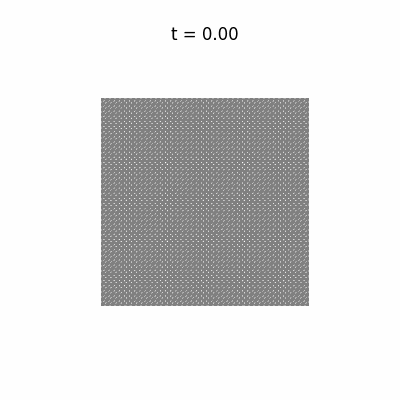

In [5]:
# First simulation in the dataset
animated_warp(u[0], Vh)

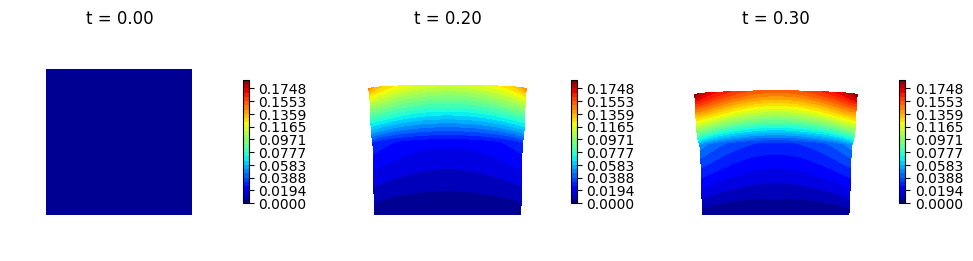

In [6]:
# Fancy plot showing warping and displacement magnitude altogether

which = 7 # First simulation

ns, nt, nh = u.shape
t = list(np.linspace(0, 1, nt))

umod = u[which].reshape(nt, -1, 2).pow(2).sum(axis = -1).sqrt()
plt.figure(figsize = (12, 4))
for i, ti in enumerate([0, 10, 15]):
  plt.subplot(1, 3, i+1)
  warped_mesh = fe.warpmesh(u[which, ti], Vh)
  delta = mu[which].item()
  WVh = fe.space(warped_mesh, 'CG', 1)

  fe.plot(umod[ti], WVh, levels = 30, vmin = umod.min(), vmax = umod.max(), colorbar = True, shrink = 0.4)
  plt.axis([-0.25, 1.25, -0.25, 1.25])
  plt.title("t = %.2f" % t[ti])
  plt.axis("off")

<font color= '#orange'>   Data Dimensions Printed:

In [7]:
ndata, ntimes, nh = u.shape
p = mu.shape[-1]
print("Trajectories:\t%d." % ndata)
print("Timesteps:\t%d." % ntimes)
print("FOM dimension:\t%d." % nh)
print("Parameters:\t%d." % p)

Trajectories:	100.
Timesteps:	51.
FOM dimension:	3362.
Parameters:	1.


#### Data Description
100 full-order simulations with:
- 51 time snapshots ($t=0$ to $t=1$ with $\Delta t=0.02$)
- 3362 spatial DoFs per snapshot ($\in \mathbb{R}^{3362}$)




<font color= '#orange'>   Time-Extended Parameter Tensor mut:

In [8]:
mut = dv.zeros(ndata, ntimes, p+1)
times = dv.tensor(np.linspace(0, 1, ntimes))
for i in range(ndata):
    mut[i,:,:p] = mu[i] # Corrected slice based on actual p
    mut[i,:, p] = times # Assign times to the correct index

Each time slice of a trajectory contains:

$$
[\mu_i, t_j]
$$
This is critical because ROM will likely use both parameter and time as input to predict displacement.

In [9]:
u = u.reshape(-1, nh)
u.shape

torch.Size([5100, 3362])

In [10]:
mut = mut.reshape(-1, p+1)
mut.shape

torch.Size([5100, 2])

## <mark>**Task 1: ROM Construction and Accuracy Evaluation**</mark></br>

In this task, we aim to build a computationally efficient Reduced Order Model (ROM) that accurately approximates the high-fidelity simulations of the parametric linear elasticity problem describing the dual-layer stunt training floor.

The available dataset of 100 full-order simulations—each corresponding to a different value of the material parameter $\delta \in [0.5, 0.9]$—is split into two parts:

* 75 simulations for training the ROM,
* 25 simulations for testing its generalization ability.

Among the standard ROM approaches (POD-NN, DL-ROM, AE+SINDy), one is selected and implemented to construct a parametric surrogate. The ROM takes as input a pair $(\delta, t)$ and returns an approximation $\tilde{u}_\delta(x, t)$ of the full solution.

The ROM is considered satisfactory if the average relative error over the test set is below 2.5%.

<font color= '#orange'>  ROM Workflow Overview

1. Computed POD basis **V** from training data (n = 16)
2. Projected FOM solutions **u** to reduced coordinates **c = u @ V**
3. Trained a neural network φ to learn the map:

   $$(μ, t) ⟼ c ∈ ℝ^{15}$$

4. Reconstructed the ROM approximation:

   $$ \tilde{u} = \hat{c} \cdot V^⊤ $$

5. Evaluated its accuracy using your `error()` function on the test set.

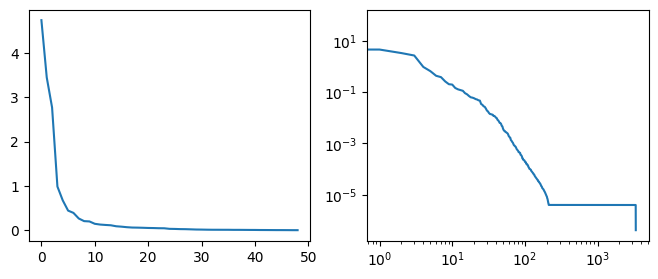

In [11]:
ntrain= 75*ntimes
from scipy.linalg import svd
X, s, Yt = svd(u[:ntrain].T, full_matrices = False)

plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
plt.plot(s[1:50])
plt.subplot(1, 2, 2)
plt.loglog(s)
plt.show()

In [12]:
# Cumulative explained variance (excluding s[0])
cum_explained = np.cumsum(s[1:]**2) / np.sum(s[1:]**2)

# Find first index where variance ≥ 99%
k99 = np.argmax(cum_explained >= 0.999) + 1  # +1 to correct for index shift
print(f"To capture 99.9% of the variance, you need {k99} modes.")

To capture 99.9% of the variance, you need 15 modes.


In [13]:
n = 16
V = X[:, :n]
V = dv.tensor(V)

In [14]:
uproj = u @ V @ V.T
print("u.shape: ", u.shape)
print("ntrain: ", ntrain)
print("u[ntrain:]: ", u[ntrain:].shape)

u.shape:  torch.Size([5100, 3362])
ntrain:  3825
u[ntrain:]:  torch.Size([1275, 3362])


In [15]:
l2 = L2(Vh)
clc()

def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, nt).sum(axis = -1)/l2(utrue).reshape(-1, nt).sum(axis = -1)).mean()

Performance Evaluation
Relative space-time $L^2$ error:
$$
\text{Test error} = \frac{1}{N_{\text{test}}} \sum_{i=1}^{N_{\text{test}}} \frac{\sum_{j=1}^{N_t} \|\mathbf{u}_{i,j} - \tilde{\mathbf{u}}_{i,j}\|_{L^2(Ω)}}{\sum_{j=1}^{N_t} \|\mathbf{u}_{i,j}\|_{L^2(Ω)}}
$$

Where:
- $\mathbf{u}_{i,j}$: $j$-th snapshot of $i$-th true FOM test trajectory
- $\tilde{\mathbf{u}}_{i,j}$: Corresponding ROM approximation

In [16]:
# Compute projection error using L2 norm over function space
avg_proj_error = error(u[ntrain:], uproj[ntrain:])

# Print as a percentage
print("Average projection error (L2): {:.2f}%".format(avg_proj_error * 100))

Average projection error (L2): 0.36%


## <mark>**POD-NN**</mark></br>

<font color= '#orange'>   Projected FOM solutions to reduced coordinates :

In [17]:
c = u @ V

c.shape

torch.Size([5100, 16])

<font color= '#orange'>  Neural Network Definition

In [18]:
# Note: phi should go from mut (p+1-dimensional) to c (n-dimensional)

phi = (
    Dense(p + 1, 128, gelu) +
    Dense(128, 128, gelu) +
    Dense(128, 64, gelu) +
    Dense(64, n, activation=None)
)
model = DFNN(phi)


<font color= '#orange'> Model Training

In [19]:
model.He()
model.train(mut, c, ntrain = ntrain, epochs = 500, loss = mse(euclidean))
model.freeze()

		Train		Test
Epoch 500:	3.23e-04	4.52e-04.

>> ETA: 0.57s.

Training complete. Elapsed time: 4 minutes 45.23 seconds.


<font color= '#orange'>  ROM Reconstruction & Error Evaluation

In [20]:
uROM = model(mut)@ V.T
print("Average relative error of POD-NN: %s." % num2p(error(u[ntrain:], uROM[ntrain:])))

Average relative error of POD-NN: 2.03%.


In [21]:
uROM.shape

torch.Size([5100, 3362])

## <mark>**Task 2: ROM Speed-Up Evaluation**</mark></br>
Quantify computational speed-up of POD-NN ROM vs FOM

####Method:
1. Selected test trajectory ( `mu[7]`)
2. Built input matrix `mu0t ∈ ℝⁿᵗ × (p+1)`:
   - Constant parameter μ₀
   - Time vector `t ∈ [0, 1]`
3. Measured ROM execution time:
   - NN prediction → POD reconstruction
4. Compared to FOM baseline (8.11s/trajectory)




In [22]:
which = 7  # test trajectory
mu0 = mu[which]          # shape: [1] if p = 1
mu0t = dv.zeros(nt, p + 1)  # shape: [nt, 2] for p = 1

mu0t[:, 0] = mu0          # Fill first column with the parameter
mu0t[:, 1] = times        # Fill second column with time
from time import perf_counter
t0 = perf_counter()
uROM0 = model(mu0t) @ V.T
t1 = perf_counter()

rom_time = t1 - t0
fom_time = 8.11
speedup = fom_time / rom_time

print("POD-NN simulation time: %.3f s" % rom_time)
print("FOM time: %.2f s → Speed-up: %.1f×" % (fom_time, speedup))


POD-NN simulation time: 0.001 s
FOM time: 8.11 s → Speed-up: 6078.7×


In [23]:
print(mu0t.shape)  # Should be (100, 1)


torch.Size([51, 2])


In [24]:
import numpy as np
repeats = 5
times = []
for _ in range(repeats):
    t0 = perf_counter()
    _ = model(mu0t) @ V.T
    t1 = perf_counter()
    times.append(t1 - t0)

rom_time = np.mean(times)
speedup = fom_time / rom_time
print("POD-NN simulation time: %.3f s" % rom_time)

print("FOM time: %.2f s → Speed-up: %.1f×" % (fom_time, speedup))


POD-NN simulation time: 0.000 s
FOM time: 8.11 s → Speed-up: 16296.9×


Result:
$$
\text{Speed-up} = \frac{\text{FOM time (8.11s)}}{\text{ROM time}}
$$

## <mark>**Task 3: Effect of Layer Thickness on Maximum Deformation**</mark></br>


The goal of this task is to study how the maximum deformation of a 2D elastic body depends on the thickness of a rigid layer, denoted by the parameter $\delta$. Specifically, we analyze the map:

$$
\delta \mapsto J(u_\delta) := \max_{(x,t) \in \Omega \times [0,T]} \|u_\delta(x,t)\|_2,
$$

where $u_\delta(x,t)$ is the displacement field for a given $\delta$, and $J(u_\delta)$ is the maximum magnitude of displacement across all time steps and spatial points — a scalar that summarizes the worst-case deformation for a simulation trajectory.

We leverage both the Full-Order Model (FOM) data and a trained Reduced-Order Model (ROM) to:

1. Compute $J(u_\delta)$ from FOM data on training and test samples.
2. Predict $J(u_\delta)$ using the ROM over a fine grid of $\delta$ values.
3. Visualize the mapping $\delta \mapsto J(u_\delta)$ and compare the ROM predictions with the FOM results.

In [25]:
uROM.shape

torch.Size([5100, 3362])

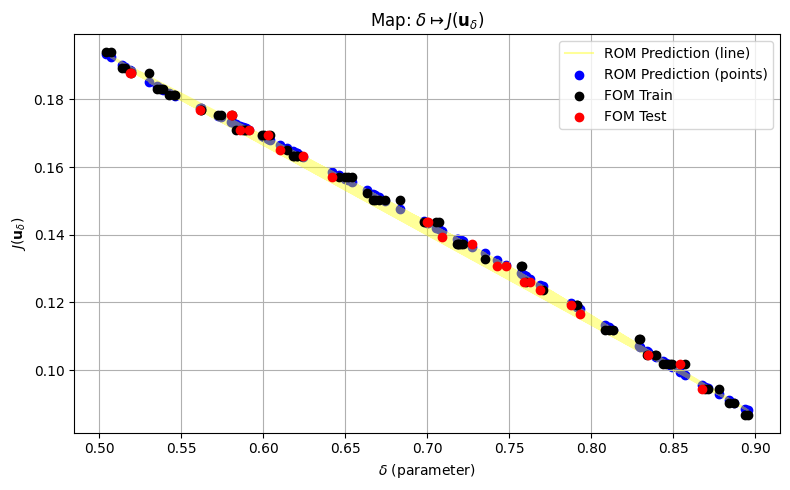

In [26]:
# reshape FOM and ROM to (ndata, ntimes, nh)
u = u.reshape(ndata, ntimes, nh)
uROM = uROM.reshape(ndata, ntimes, nh)

def compute_J(u_i):
    # Reshape to (ntimes, npoints, 2) to compute vector norms
    u_i = u_i.reshape(ntimes, -1, 2) #Each u_i is of shape (51, 3362)(a trajectory of a simulation over time)
    return u_i.norm(dim=-1).max().item()

# Compute J values
J_fom = [compute_J(u_i) for u_i in u]
J_rom = [compute_J(u_i) for u_i in uROM]

# Extract mu from mut (shape assumed: (ndata, ntimes, p+1))
mu_np = mut[::ntimes, 0].cpu().numpy() # Corrected indexing

# Plot
plt.figure(figsize=(8, 5))
plt.plot(mu_np, J_rom, color='yellow', alpha=0.4, label='ROM Prediction (line)')
plt.scatter(mu_np, J_rom, color='#0000FF', label='ROM Prediction (points)')

# FOM points
plt.scatter(mu[:75], J_fom[:75], color='black', label='FOM Train', zorder=3)
plt.scatter(mu[75:], J_fom[75:], color='red', label='FOM Test', zorder=3)

plt.xlabel(r"$\delta$ (parameter)")
plt.ylabel(r"$J(\mathbf{u}_\delta)$")
plt.title(r"Map: $\delta \mapsto J(\mathbf{u}_\delta)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Maximum Deformation Functional

To assess the effect of the material parameter $\delta$ (the thickness of the rigid floor layer) on system behavior, we compute the functional:

$$
J(u_\delta) := \max_{(x,t) \in \Omega \times [0,T]} \|u_\delta(x,t)\|_2,
$$

which measures the maximum displacement magnitude across space and time. Since the displacement field $u$ is vector-valued in $\mathbb{R}^2$, we compute the Euclidean norm $\|u(x,t)\|_2 = \sqrt{u_x^2 + u_y^2}$ at each point, and then take the global maximum. This allows us to evaluate and compare deformation levels for different material configurations.

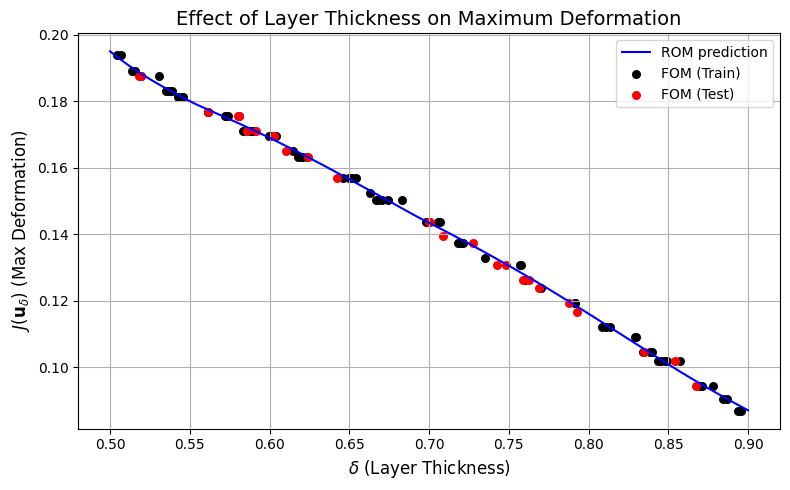

In [27]:
import matplotlib.pyplot as plt

# --- Compute J(u_δ) for the FOM data ---
def max_deformation(u):

    if u.ndim == 2:  # flattened shape
        u = u.reshape(u.shape[0], -1, 2)
    return np.max(np.linalg.norm(u, axis=-1))  # max over space and time

# Ensure u is in the correct shape (ndata, ntimes, nh) for this section if it was reshaped earlier
if u.ndim == 2:
     u = u.reshape(ndata, ntimes, nh)


# FOM values
J_train = [max_deformation(u[i].cpu().numpy()) for i in range(75)] # Ensure data is on CPU for numpy
J_test = [max_deformation(u[i].cpu().numpy()) for i in range(75, 100)] # Ensure data is on CPU for numpy

# Ensure mu is in the correct shape (ndata, p) for this section
if mu.ndim == 2:
    delta_train = mu[:75].flatten().cpu().numpy() # Ensure data is on CPU for numpy
    delta_test = mu[75:].flatten().cpu().numpy()   # Ensure data is on CPU for numpy
elif mu.ndim == 1: # Handle the case where mu might already be flattened if p=1
    delta_train = mu[:75].cpu().numpy()
    delta_test = mu[75:].cpu().numpy()


# --- ROM Prediction over a fine δ grid ---
delta_grid = np.linspace(0.5, 0.9, 200)
J_rom = []

# Re-define times as a dv.tensor for this loop's scope
times = dv.tensor(np.linspace(0, 1, ntimes))


for delta in delta_grid:
    # replicate δ across all 51 time steps
    input_rom = np.zeros((ntimes, p + 1))
    input_rom[:, 0] = delta
    input_rom[:, 1] = times.cpu().numpy().flatten() # Access the underlying numpy array and flatten if necessary

    input_rom_tensor = dv.tensor(input_rom)
    coeffs = model(input_rom_tensor)           # POD coefficients
    u_pred = coeffs @ V.T                      # reconstruct u from POD basis
    J_rom.append(max_deformation(u_pred.cpu().numpy())) # Ensure data is on CPU for numpy


# --- Plotting ---
plt.figure(figsize=(8,5))
plt.plot(delta_grid, J_rom, label='ROM prediction', color='blue')
plt.scatter(delta_train, J_train, color='black', label='FOM (Train)', s=30)
plt.scatter(delta_test, J_test, color='red', label='FOM (Test)', s=30)
plt.xlabel(r'$\delta$ (Layer Thickness)', fontsize=12)
plt.ylabel(r'$J(\mathbf{u}_\delta)$ (Max Deformation)', fontsize=12)
plt.title('Effect of Layer Thickness on Maximum Deformation', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Conclusion

- The maximum deformation $J(u_\delta)$ decreases with increasing rigid layer thickness $\delta$. This aligns with physical intuition: a thicker rigid layer offers more resistance, reducing deformation.

- The trained ROM provides accurate and efficient predictions of deformation behavior across the $\delta$ domain.

- This demonstrates the ROM's value in parameter studies and design space exploration, offering fast and reliable evaluations without solving the full PDE system.

## <mark>**Task 4: Time-Evolution of Maximum Displacement**</mark></br>

<font color= '#orange'>  Deformation Analysis Goal

#### Objective
Analyze temporal evolution of maximum floor deformation for layer thickness parameter:
$$\delta \in [0.5, 0.9]$$

#### Methodology
1. **ROM Simulation**:
   - Generate displacement fields $u_\delta(x,t)$ using reduced-order model

2. **Deformation Computation**:
   - Calculate maximum displacement magnitude per timestep:
   $$J_t(u_\delta) := \max_{x \in \Omega} \|u_\delta(x,t)\|$$

3. **Visualization**:
   - Plot $J_t(u_\delta)$ vs time for different $\delta$ values
   - Create comparative analysis across parameter space

4. **Critical Analysis**:
   - Identify time of peak deformation for each $\delta$
   - Characterize how peak timing shifts with thickness changes

Generate 1001 parameter and Build ROM input for each (δ, t) pair

In [28]:
delta_vals = np.linspace(0.5, 0.9, 1001)  # Shape: (1001,)
ntimes = 51
times = np.linspace(0, 1, ntimes)        # Shape: (51,)

delta_grid = np.repeat(delta_vals[:, None], ntimes, axis=1)     # (1001, 51)
time_grid = np.repeat(times[None, :], 1001, axis=0)              # (1001, 51)

mut_query = np.stack([delta_grid, time_grid], axis=-1).reshape(-1, 2)  # (1001*51, 2)

Predict ROM solution
python
Copy code


In [29]:
c_pred = model(mut_query)              # (1001*51, 16)
# Convert c_pred from numpy array to PyTorch Tensor
c_pred_tensor = dv.tensor(c_pred)
u_pred = c_pred_tensor @ V.T                  # (1001*51, 3362)
u_pred = u_pred.reshape(1001, ntimes, -1)

In [30]:
# Reshape to (1001, ntimes, npoints, 2) → for computing norm
u_pred_vec = u_pred.reshape(1001, ntimes, -1, 2)

# Euclidean norm at each (x, t)
u_norm = u_pred_vec.norm(dim=-1)  # (1001, ntimes, npoints)

# Max over space
Jt = u_norm.max(dim=-1).values     # (1001, ntimes)


In [31]:
print("𝛿=0.5, t=0.2 → Jt:", Jt[0, 10].item())
print("𝛿=0.9, t=0.2 → Jt:", Jt[-1, 10].item())


𝛿=0.5, t=0.2 → Jt: 0.1471523642539978
𝛿=0.9, t=0.2 → Jt: 0.0814456194639206


At the same time point t=0.2:

| 𝛿 Value | Top Layer Thickness | Bottom Layer Thickness | Overall Floor | Deformation Behavior |
|---|---|---|---|---|
| 0.5 | Thick (soft) | Thin (stiff) | **Softer** | High |
| 0.9 | Thin (soft) | Thick (stiff) | **Stiffer** | Lower |

(1001, 4)


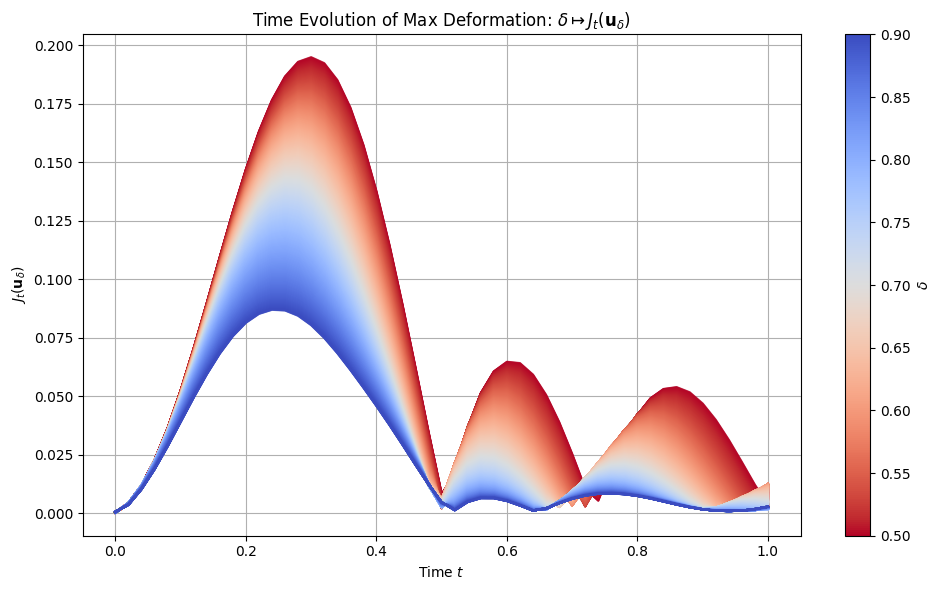

In [32]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = cm.coolwarm(np.linspace(1, 0, 1001))  # red → blue

# Make sure 'times' is a numpy array for plotting
if not isinstance(times, np.ndarray):
    times = times.cpu().numpy()
print(colors.shape)
for i in range(1001):
    plt.plot(times, Jt[i].cpu().numpy(), color=(colors[i]), alpha=0.7) # Ensure Jt[i] is on CPU for numpy plotting

plt.xlabel("Time $t$")
plt.ylabel(r"$J_t(\mathbf{u}_\delta)$")
plt.title(r"Time Evolution of Max Deformation: $\delta \mapsto J_t(\mathbf{u}_\delta)$")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm_r, norm=plt.Normalize(0.5, 0.9))


sm.set_array([])
# Get the current axes and pass it to the colorbar function
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label(r"$\delta$")

plt.grid(True)
plt.tight_layout()
plt.show()

---
## Time-Dependent Forcing

You apply a localized sinusoidal force in the vertical direction only for $t \in [0, 0.5]$. This "kick" travels through the medium like a wave, and its response depends on material stiffness.

This plot shows how the maximum deformation changes over time for varying values of 𝛿



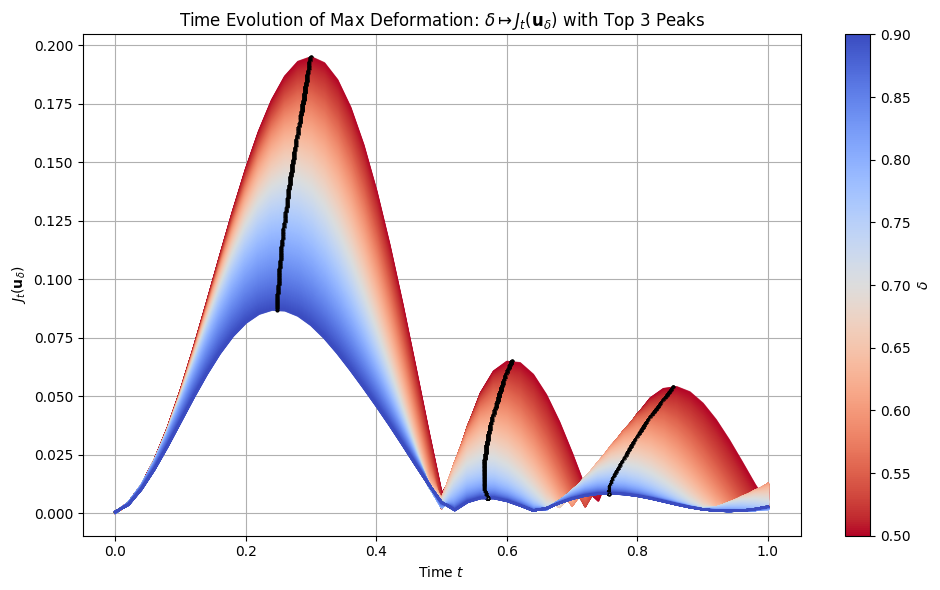

In [33]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

# Prepare delta and times
delta_vals = np.linspace(0.5, 0.9, 1001)
colors = cm.coolwarm(np.linspace(1, 0, 1001))  # red → blue

if not isinstance(times, np.ndarray):
    times = times.cpu().numpy()

t_max_vals = []
j_max_vals = []

# === PLOT ===
plt.figure(figsize=(10, 6))

for i in range(1001):
    jt = Jt[i].cpu().numpy()

    # Plot main line
    plt.plot(times, jt, color=colors[i], alpha=0.7)

    # Interpolate to finer time grid
    interp_func = interp1d(times, jt, kind='cubic')
    fine_t = np.linspace(times.min(), times.max(), 1000)
    jt_fine = interp_func(fine_t)

    # Find local peaks
    peak_indices, _ = find_peaks(jt_fine)
    peak_values = jt_fine[peak_indices]

    if len(peak_indices) >= 1:
        # Sort peaks by value (descending) and take top 3
        top_indices = np.argsort(peak_values)[-3:][::-1]
        for j, idx in enumerate(top_indices):
            t_peak = fine_t[peak_indices[idx]]
            j_peak = jt_fine[peak_indices[idx]]
            color = 'ko' if j == 0 else 'o'  # black for highest, gray for others
            plt.plot(t_peak, j_peak, color, markersize=2, markerfacecolor='gray' if j > 0 else 'black', markeredgecolor='black')

        # Store global max (for optional analysis)
        t_max_vals.append(fine_t[peak_indices[top_indices[0]]])
        j_max_vals.append(jt_fine[peak_indices[top_indices[0]]])
    else:
        # Fallback in case no peaks are found (unlikely)
        idx = np.argmax(jt_fine)
        plt.plot(fine_t[idx], jt_fine[idx], 'ko', markersize=2)
        t_max_vals.append(fine_t[idx])
        j_max_vals.append(jt_fine[idx])

plt.xlabel("Time $t$")
plt.ylabel(r"$J_t(\mathbf{u}_\delta)$")
plt.title(r"Time Evolution of Max Deformation: $\delta \mapsto J_t(\mathbf{u}_\delta)$ with Top 3 Peaks")

# Add colorbar (reverse colormap for consistency)
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm_r, norm=plt.Normalize(0.5, 0.9))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label(r"$\delta$")

plt.grid(True)
plt.tight_layout()
plt.show()


| δ Value                  | Layer Setup                             | Max Deformation | Peak Time   |
| ------------------------ | --------------------------------------- | --------------- | ----------- |
| **High δ** (≈ 0.9, blue) | Thicker rigid layer, thinner soft layer | Lower           | **Earlier** |
| **Low δ** (≈ 0.5, red)   | Thinner rigid layer, thicker soft layer | Higher          | **Later**   |


As δ increases (thinner soft layer, stiffer floor):

* The maximum deformation occurs earlier in time.
* The deformation peak is smaller.

As δ decreases (thicker soft layer, softer floor):

* The maximum deformation occurs later in time.
* The deformation peak is larger.

🔍 **Physical Interpretation:**
A softer floor (small δ) acts like a cushion — it takes more time to fully compress, so the deformation builds up gradually and peaks later.

A stiffer floor (large δ) resists deformation more — it reacts faster to the impact but doesn’t deform as much.